# Data loading from BQ and language detection
In this file we show the functions that we used to
- import and format the data from the BQ tables
- using the external language detection library to filter our unlabeled comments

In this version we do not use the actual table names.

# 1. Import the data from Big Query.

To import the data from BQ we have used the tutorial "Visualizing BigQuery public data that was located in the tutorials folder of repo.

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
# !pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

client = bigquery.Client()

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [7]:
sql_labeled = """
SELECT * FROM `BQ TABLE NAME` WHERE NOT sentiment_label=0
"""


sql_unlabeled = """
SELECT * FROM `BQ TABLE NAME` 
WHERE char_length(message) > 10
AND message NOT LIKE '%http%'
ORDER BY RAND()
LIMIT 10000
"""

'''
Pre-processing of the labeled data
'''
fb_comments_labeled_df = client.query(sql_labeled).to_dataframe()
# drop duplicates
fb_comments_labeled_df = fb_comments_labeled_df.drop_duplicates(subset='comment_id')
# Shuffle rows and change the sentiment_label values
fb_comments_labeled_df = fb_comments_labeled_df.sample(frac=1).reset_index(drop=True) # shuffle rows of dataframe
fb_comments_labeled_df['sentiment_label'] = fb_comments_labeled_df['sentiment_label'].map({1:'pos', -1:'neg'})

# Drop some labeled comments to adjust the percentage. 
n_wanted = 982
n_actual = len(fb_comments_labeled_df)
n_to_drop = n_actual - n_wanted
fb_comments_labeled_df.drop(fb_comments_labeled_df.tail(n_to_drop).index, inplace=True)
# save the data as pkl
fb_comments_labeled_df.to_pickle("./labeled_filtered_comments.pkl")

'''
Pre-processing of the unlabeled data
'''
unlabeled_df = client.query(sql_unlabeled).to_dataframe()
print(len(unlabeled_df), " unlabeled comments before removing stuff")
# filter the unlabeled data to remove entries that are labeled
fb_comments_unlabeled_df = unlabeled_df[~unlabeled_df.comment_id.isin(fb_comments_labeled_df.comment_id)]
print("You have: ", len(fb_comments_unlabeled_df), " unlabeled comments.")

fb_comments_unlabeled_df.head()
fb_comments_labeled_df.head()
print("You're using: ", len(fb_comments_labeled_df), " / ", n_actual ," labeled comments.")
n_neg, n_pos = fb_comments_labeled_df["sentiment_label"].value_counts()[0], fb_comments_labeled_df["sentiment_label"].value_counts()[1]
print("Negative: %d%% (%d)" %(n_neg*100/len(fb_comments_labeled_df), n_neg))
print("Positive: %d%% (%d)" %(n_pos*100/len(fb_comments_labeled_df), n_pos))

8909  unlabeled comments before removing stuff
You have:  7927  unlabeled comments.
You're using:  982  /  982  labeled comments.
Negative: 74% (728)
Positive: 25% (254)


# 2. Language detection and filtering.
Remove non Swedish comments.

In [ ]:
#--------------------------------
# Use language detection library to remove comments in other languages
# see: https://pypi.org/project/langdetect/
#--------------------------------

# !pip install langdetect
from langdetect import detect

langs = {}
lang_list = []
print('Detecting languages in unlabeled data...')

# Loop through all unlabeled data and classify language using external library

for index, row in fb_comments_unlabeled_df.iterrows():
    text = row['message']
    try:
        pred = detect(text) # use langdetect library to get langauge
    except:
        print('could not detect language for the text: ', text)
        lang_list.append('N/A')
    else:
        lang_list.append(pred)
        if pred in langs.keys():
            data = langs[pred]
            data.append(text)
            langs[pred] = data
        else:
            langs[pred] = [text]

# Add a language column to the df
df_with_lang = fb_comments_unlabeled_df.copy()
df_with_lang['language'] = lang_list

# drop rows that do not have sve, no or da lang
ok_languages = ['sv', 'no', 'da']
fb_comments_unlabeled_df = df_with_lang[df_with_lang['language'].isin(ok_languages)]
print("After removing unsupported languages")
print("You have ", len(fb_comments_unlabeled_df), " unlabeled comments")

# Saving the filtered unlabeled DataFrame to not have to run language detection every time..
fb_comments_unlabeled_df.to_pickle("./unlabeled_filtered_comments.pkl")

34  languages detected


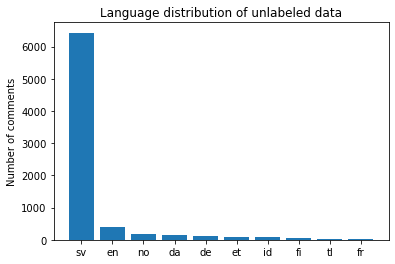

In [11]:
#--------------------------------
# Calculate and plot some statistics about the languages
#--------------------------------
import matplotlib.pyplot as plt


print(len(langs.keys()), ' languages detected')
lan_labels = list(langs.keys())
lan_values = []
for comment_list in langs.values():
    lan_values.append(len(comment_list))

# sort by number of comments, and only plot the top 10 detected languages
lan_values, lan_labels = zip(*sorted(zip(lan_values, lan_labels), reverse=True))

# Set number of languages to include in plot
num_langs_in_plot = 10
if len(langs.keys()) < 10:
    num_langs_in_plot = len(langs.keys())
lan_labels = lan_labels[:num_langs_in_plot]
lan_values = lan_values[:num_langs_in_plot]
x_pos = np.arange(len(lan_labels))

fig, ax = plt.subplots()

p1 = ax.bar(x_pos, lan_values, align='center')
ax.set_xticks(x_pos)
ax.set_xticklabels(lan_labels)
ax.set_ylabel('Number of comments')
ax.set_title('Language distribution of unlabeled data')
plt.show()